## Experimenting with opencv

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

imagePath = "BCCD/JPEGImages"
csvPath = "BCCD/CSVAnnotations"

# red blood cells are red, platelets green, white blood cells are blue
colors = {'RBC': (255,0,0), 'Platelets': (0,255,0), 'WBC': (0,0,255)}

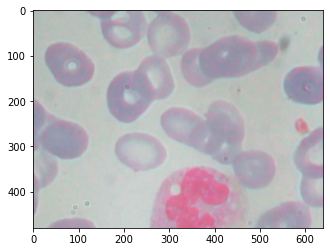

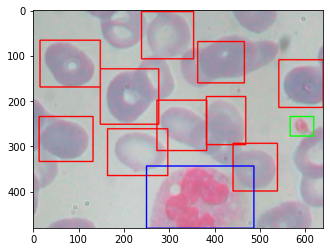

In [2]:
# Show example image and the objects
fileNum = "315"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1251


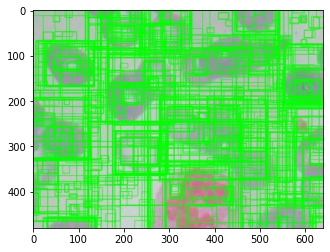

In [3]:
cv2.setUseOptimized(True);
# draw all bounding boxes produced by selective search
img = cv2.imread(os.path.join(imagePath, jpgFile))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imgOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imgOut)

In [27]:
# Calculate intersection/union ratio
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [28]:
IMG_SIZE = 224

In [29]:
# Create our training set from the proposed regions. For each image take at most MAXCOUNT each
# of positive and negative samples to make an even training set
MAXCOUNT = 30

labels = {'WBC': 3, 'RBC': 2, 'Platelets': 1, 'Background': 0}

train_images=[]
train_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for i, filename in enumerate(os.listdir(imagePath)):
    print(i, filename)
    csvName = filename.split(".")[0]+".csv"
    image = cv2.imread(os.path.join(imagePath, filename))
    objectsDf = pd.read_csv(os.path.join(csvPath, csvName))
    objects = []
    for idx, row in objectsDf.iterrows():
        filename, cell_type, xmin, xmax, ymin, ymax = row
        if xmin < xmax and ymin < ymax:
            objects.append({"x1": xmin, "x2": xmax, "y1": ymin, "y2": ymax, "label": cell_type})
        
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imgout = image.copy()
    
    trueCount = 0
    falseCount = 0
    for (x,y,w,h) in rects[:min(2000, len(rects))]:
        rect = {"x1": x, "x2": x+w, "y1": y, "y2": y+h}
        if trueCount < MAXCOUNT or falseCount < MAXCOUNT:
            for obj in objects:
                iou = get_iou(obj, rect)
                if trueCount < MAXCOUNT and iou > 0.7:
                    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(labels[obj['label']])
                    trueCount += 1

                if falseCount < MAXCOUNT and iou < 0.3:
                    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(0)
                    falseCount += 1
        else:
            break

0 BloodImage_00315.jpg
1 BloodImage_00301.jpg
2 BloodImage_00117.jpg
3 BloodImage_00103.jpg
4 BloodImage_00063.jpg
5 BloodImage_00077.jpg
6 BloodImage_00088.jpg
7 BloodImage_00249.jpg
8 BloodImage_00261.jpg
9 BloodImage_00275.jpg
10 BloodImage_00274.jpg
11 BloodImage_00260.jpg
12 BloodImage_00248.jpg
13 BloodImage_00089.jpg
14 BloodImage_00076.jpg
15 BloodImage_00062.jpg
16 BloodImage_00300.jpg
17 BloodImage_00314.jpg
18 BloodImage_00302.jpg
19 BloodImage_00100.jpg
20 BloodImage_00114.jpg
21 BloodImage_00048.jpg
22 BloodImage_00074.jpg
23 BloodImage_00276.jpg
24 BloodImage_00262.jpg
25 BloodImage_00289.jpg
26 BloodImage_00288.jpg
27 BloodImage_00263.jpg
28 BloodImage_00277.jpg
29 BloodImage_00075.jpg
30 BloodImage_00049.jpg
31 BloodImage_00115.jpg
32 BloodImage_00101.jpg
33 BloodImage_00317.jpg
34 BloodImage_00303.jpg
35 BloodImage_00307.jpg
36 BloodImage_00313.jpg
37 BloodImage_00111.jpg
38 BloodImage_00139.jpg
39 BloodImage_00071.jpg
40 BloodImage_00065.jpg
41 BloodImage_00059.jpg
42

333 BloodImage_00092.jpg
334 BloodImage_00079.jpg
335 BloodImage_00045.jpg
336 BloodImage_00125.jpg
337 BloodImage_00333.jpg
338 BloodImage_00327.jpg
339 BloodImage_00331.jpg
340 BloodImage_00325.jpg
341 BloodImage_00319.jpg
342 BloodImage_00133.jpg
343 BloodImage_00127.jpg
344 BloodImage_00047.jpg
345 BloodImage_00053.jpg
346 BloodImage_00090.jpg
347 BloodImage_00245.jpg
348 BloodImage_00251.jpg
349 BloodImage_00279.jpg
350 BloodImage_00292.jpg
351 BloodImage_00293.jpg
352 BloodImage_00287.jpg
353 BloodImage_00278.jpg
354 BloodImage_00250.jpg
355 BloodImage_00244.jpg
356 BloodImage_00091.jpg
357 BloodImage_00052.jpg
358 BloodImage_00046.jpg
359 BloodImage_00126.jpg
360 BloodImage_00132.jpg
361 BloodImage_00318.jpg
362 BloodImage_00324.jpg
363 BloodImage_00330.jpg


In [30]:
xTrain = np.array(train_images)
yTrain = np.array(train_labels)

In [31]:
print("Dataset shape: {}".format(xTrain.shape))
print("Label shape: {}".format(yTrain.shape))

Dataset shape: (20045, 224, 224, 3)
Label shape: (20045,)


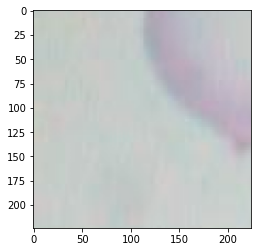

In [10]:
plt.imshow(xTrain[0])

## Training model

Referring to https://github.com/ByeongGil-Jung/Keras-CNN-RGB-Images/blob/master/src/d2_keras.ipynb

In [11]:
import keras

Using TensorFlow backend.


In [32]:
num_classes = 4
labels_one_hot = keras.utils.to_categorical(yTrain, num_classes)

In [33]:
xTrain = xTrain.astype("float32")

In [34]:
xTrain /= 255.

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xTrain, labels_one_hot, test_size=0.1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [36]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2), padding="same"))

model.add(Conv2D(32, (5, 5), activation="relu", strides=(2,2), padding="same"))
model.add(MaxPooling2D(pool_size=(2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(124, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 64)       

In [19]:
# load previous weights
model.load_weights('weights.h5')

In [38]:
epochs = 25

In [39]:
batch_size = 128
lr = 0.001
decay = 1e-6

optimizer = keras.optimizers.RMSprop(lr=lr, decay=decay)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [40]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, validation_data=(x_test, y_test), 
    shuffle=True, 
    verbose=1
)

Train on 18040 samples, validate on 2005 samples
Epoch 1/25
18040/18040 [==============================] - 428s 24ms/step - loss: 0.9279 - accuracy: 0.5277 - val_loss: 0.6867 - val_accuracy: 0.6065
Epoch 2/25
18040/18040 [==============================] - 421s 23ms/step - loss: 0.6666 - accuracy: 0.6609 - val_loss: 0.4525 - val_accuracy: 0.8334
Epoch 3/25
18040/18040 [==============================] - 467s 26ms/step - loss: 0.4943 - accuracy: 0.8067 - val_loss: 0.3192 - val_accuracy: 0.8698
Epoch 4/25
18040/18040 [==============================] - 449s 25ms/step - loss: 0.3616 - accuracy: 0.8635 - val_loss: 0.3265 - val_accuracy: 0.8688
Epoch 5/25
18040/18040 [==============================] - 436s 24ms/step - loss: 0.3142 - accuracy: 0.8849 - val_loss: 0.2497 - val_accuracy: 0.9052
Epoch 6/25
18040/18040 [==============================] - 435s 24ms/step - loss: 0.2655 - accuracy: 0.9058 - val_loss: 0.1964 - val_accuracy: 0.9307
Epoch 7/25
18040/18040 [==============================] -

In [41]:
model.save_weights("./weights.h5")

In [58]:
y_pred = model.predict(xTrain[:10])
y_pred_label = np.argmax(y_pred, axis=1)

In [59]:
xTrain[:10].shape

(10, 224, 224, 3)

## Predicting

In [62]:
labelColors = {1: (0,255,0), 2: (255,0,0), 3: (0,0,255)}

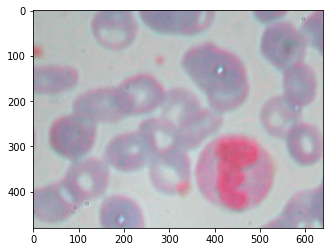

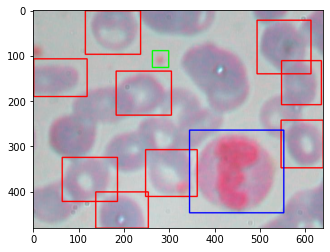

In [79]:
# Show example image and the objects
fileNum = "200"
jpgFile = "BloodImage_00" + fileNum + ".jpg"
csvFile = "BloodImage_00" + fileNum + ".csv"
img = cv2.imread(os.path.join(imagePath, jpgFile))
plt.imshow(img)

objects = pd.read_csv(os.path.join(csvPath, csvFile))
for i, row in objects.iterrows():
    filename, cell_type, xmin, xmax, ymin, ymax = row
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[cell_type], 2)
plt.figure()
plt.imshow(img)

1978
3


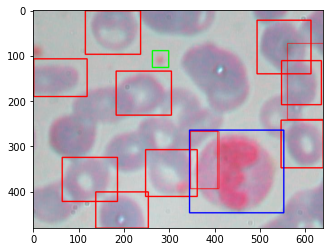

In [80]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imgOut = img.copy()
print(len(rects))
count = 0
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    resized = cv2.resize(imgout[y:y+h,x:x+w], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA).astype('float32')
    resized /= 255. 
    resized = np.expand_dims(resized, axis=0)
    pred = model.predict(resized)
    label = (np.argmax(pred, axis=1)[0])
    if label > 0 and pred[0][label] >= 1:
        count += 1
        cv2.rectangle(imgOut, (x, y), (x+w, y+h), labelColors[label], 1, cv2.LINE_AA)
plt.imshow(imgOut)
print(count)